### Importing packages

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import cv2
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

## Data Analysis

In [2]:
df = pd.read_csv("Corona_NLP_train.csv")
df1= pd.read_csv("Corona_NLP_test.csv")

In [3]:
frames=[df,df1]
df=pd.concat(frames)

In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [6]:
df.shape

(44955, 6)

In [7]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [8]:
un=df.OriginalTweet.value_counts()

In [9]:
un.shape

(44955,)

In [11]:
missing_values = pd.DataFrame()
missing_values['column'] = df.columns
missing_values['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent']>0]

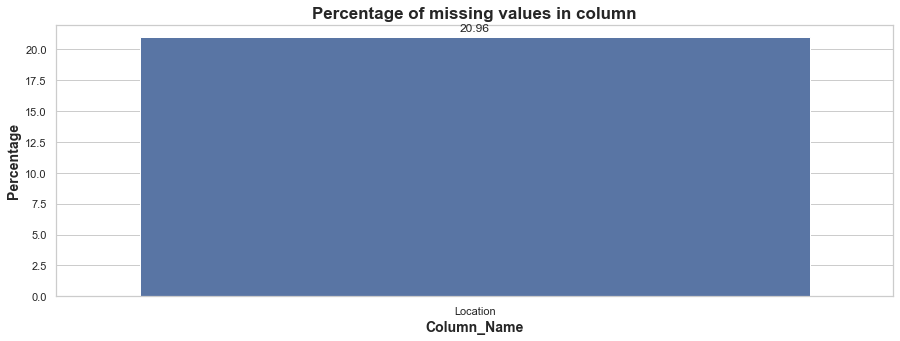

In [12]:
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid', color_codes=True)
splot=sns.barplot(x='column', y='percent', data=missing_values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.title("Percentage of missing values in column",fontweight="bold",size=17)
plt.show()

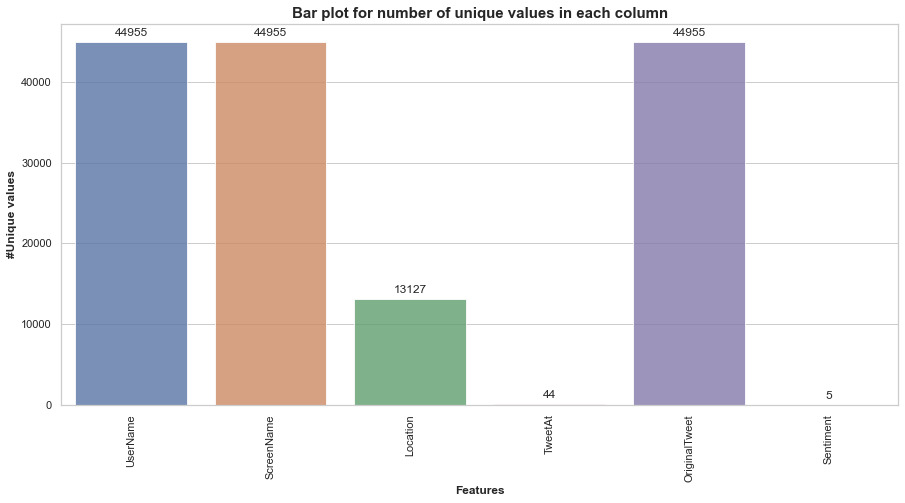

In [13]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

## Preprocessing


#### 1. Remove @user

In [14]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [15]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [16]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"


#### 2. Remove https and urls

In [17]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [18]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...


In [19]:
df.shape

(44955, 7)

#### 3. Remove special characters, numbers, punctuations

In [20]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

#### 4. Remove Short Words

In [21]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

#### 5. Tokenization

In [22]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

#### 6. Stemming

In [23]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [24]:
tokenized_tweet= tokenized_tweet.to_frame()

In [25]:
tokenized_tweet=tokenized_tweet.values

In [26]:
len(tokenized_tweet)

44955

In [27]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i][0] = ' '.join(tokenized_tweet[i][0])
    
# change df['Tweet'] to tokenized_tweet

In [28]:
tokenized_tweet.shape


(44955, 1)

In [29]:
df['Tweet']  = tokenized_tweet

In [30]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...


## Creating Wordcloud

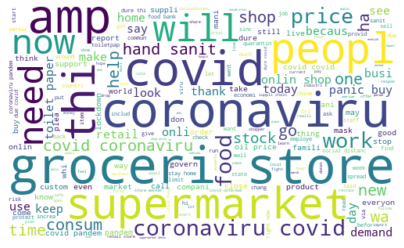

In [74]:
# create text from all tweets
all_words = ' '.join([text for text in df['Tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=500, height=300, background_color='white',random_state=21, max_font_size=90).generate(all_words)

plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [33]:
def create_blank_black_canvas(width, height):
    image = np.zeros((height, width, 3), np.uint8)
    return image

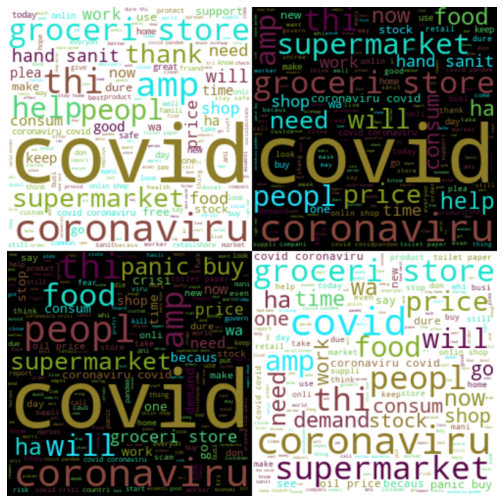

In [79]:
canvas = create_blank_black_canvas(800, 800)
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Extremely Positive']])
wordcloud1 = WordCloud(width=250, height=250, random_state=21, max_font_size=90,  background_color='white').generate(normal_words)

normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Positive']])
wordcloud2 = WordCloud(width=250, height=250, random_state=21, max_font_size=90).generate(normal_words)

normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Extremely Negative']])
wordcloud3 = WordCloud(width=250, height=250, random_state=21, max_font_size=90).generate(normal_words)

normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Negative']])
wordcloud4 = WordCloud(width=250, height=250, random_state=21, max_font_size=90,background_color='white').generate(normal_words)

wordcloud1.to_file("wordCloud1.png")
wordcloud2.to_file("wordCloud2.png")
wordcloud3.to_file("wordCloud3.png")
wordcloud4.to_file("wordCloud4.png")

tl = cv2.imread('wordCloud1.png')
tr = cv2.imread('wordCloud2.png')
bl = cv2.imread('wordCloud3.png')
br = cv2.imread('wordCloud4.png')

tl = cv2.resize(tl, (400,400))
tr = cv2.resize(tr, (400,400))
bl = cv2.resize(bl, (400,400))
br = cv2.resize(br, (400,400))

canvas[0:400,0:400] = tl
canvas[0:400,400:800] = tr
canvas[400:800,0:400] = bl
canvas[400:800,400:800] = br

plt.figure(figsize=(11,9))
plt.imshow(canvas,interpolation="bilinear")
plt.axis('off')
plt.show()

### Understanding Hashtags

In [39]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [40]:
# extracting hashtags from non racist/sexist tweets
HT_Extremely_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Positive'])
HT_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Negative'])
HT_Extremely_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Negative'])



# unnesting list
HT_Extremely_Positive = sum(HT_Extremely_Positive, [])
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])
HT_Extremely_Negative = sum(HT_Extremely_Negative,[])

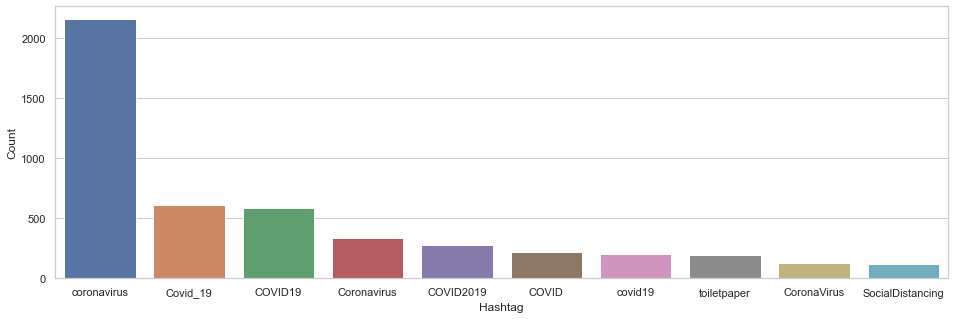

In [41]:
# making frequency distribution top 10 Extremely Positive hashtags
a = nltk.FreqDist(HT_Extremely_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

### Extracting features from cleaned tweets

In [43]:
new_df = df[['Tweet','Sentiment']]

In [44]:
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [45]:
df['Sentiment'].value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

In [46]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jyoti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [48]:
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                            []
1       [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e,  , c, n, c,  , l,  , w, h,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, ...
2                                                           [c, r, n, v, r, u,  , u, r, l,  , w, l, w, r, h,  , g, v, e,  , e, l, e, r, l,  , b, l,  , e, c,  , h, p,  , h, u, r,  ,  , c, v,  , u, b, r, e, k]
3       [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  , e, p,  , p, l, e,  , n,  , p, n, c,  , h, e, r, e,  , w, l, l,  , e, n, u, g, h,  , f,  , f, r,  , e, v, e, r, n,  , u,  , n,  , k, ...
4       [r, e,  , u, p, e, r, r, k, e,  , u, r, e,  , h, e,  , #, c, v,  , u, b, r, e, k,  , n,  , b, e, c, u,  , p, r, n,  , b, u,  , b, e, c, u,  , f,  , c, k,  , l, 

## Train-Test Split

In [49]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (35964, 2)
valid shape :  (8991, 2)


In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (35964, 28209)
X_train.shape :  (8991, 28209)
y_train.shape :  (35964,)
y_valid.shape :  (8991,)


### 5 class to 2 class

In [51]:
Y_train=[]

for i in y_train:
    if i=='Positive' or i=="Extremely Positive" or i=='Neutral':
        Y_train.append(1)
    else: 
        Y_train.append(0)

In [52]:
Y_valid=[]

for i in y_valid:
    if i=='Positive' or i=="Extremely Positive" or i=='Neutral':
        Y_valid.append(1)
    else: 
        Y_valid.append(0)

## Models
### Logistic Reg


In [66]:
logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(Y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,Y_train))
print("Testing accuracy Score : ",logreg_accuracy )
print("Mean Squared Error : ", mean_squared_error(Y_valid, logreg_prediction))
print(classification_report(logreg_prediction,Y_valid))       

Training accuracy Score    :  0.9348237126014903
Testing accuracy Score :  0.8624179735290847
Mean Squared Error :  0.13758202647091536
Mean Absolute Error :  0.13758202647091536
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      3093
           1       0.92      0.87      0.89      5898

    accuracy                           0.86      8991
   macro avg       0.84      0.86      0.85      8991
weighted avg       0.87      0.86      0.86      8991



### Multinomial Naive Bayes

In [67]:
mnb = MultinomialNB()

# Training 
mnb.fit(X_train,Y_train)

#Predictions
pred=mnb.predict(X_valid)

mnb_accuracy = accuracy_score(Y_valid,pred)
print("Training accuracy Score    : ", mnb.score(X_train,Y_train))
print("Testing accuracy Score : ", mnb_accuracy )
print("Mean Squared Error : ", mean_squared_error(Y_valid, pred))
print(classification_report(pred,Y_valid)) 

Training accuracy Score    :  0.8576632187743299
Testing accuracy Score :  0.7957957957957958
Mean Squared Error :  0.2042042042042042
Mean Absolute Error :  0.2042042042042042
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      3174
           1       0.86      0.82      0.84      5817

    accuracy                           0.80      8991
   macro avg       0.78      0.78      0.78      8991
weighted avg       0.80      0.80      0.80      8991



### SVM


In [76]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, Y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(Y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,Y_train))
print("Testing accuracy Score : ",svc_accuracy )
print("Mean Squared Error : ", mean_squared_error(Y_valid, svc_prediction))
print(classification_report(svc_prediction,Y_valid))

Training accuracy Score    :  0.9561784006228451
Testing accuracy Score :  0.8399510621732844
Mean Squared Error :  0.16004893782671561
              precision    recall  f1-score   support

           0       0.69      0.86      0.77      2765
           1       0.93      0.83      0.88      6226

    accuracy                           0.84      8991
   macro avg       0.81      0.84      0.82      8991
weighted avg       0.86      0.84      0.84      8991



### Decision Tree

In [89]:
dtc = DecisionTreeClassifier(criterion='gini',max_depth=5)
dtc.fit(X_train, Y_train)
dtc_prediction = svc.predict(X_valid)
dtc_accuracy = accuracy_score(Y_valid,dtc_prediction)

print("Training accuracy Score    : ",dtc.score(X_train,Y_train))
print("Testing accuracy Score : ",dtc_accuracy )
print("Mean Squared Error : ", mean_squared_error(Y_valid, dtc_prediction))
print(classification_report(dtc_prediction,Y_valid))

Training accuracy Score    :  0.6987265042820598
Testing accuracy Score :  0.8399510621732844
Mean Squared Error :  0.16004893782671561
              precision    recall  f1-score   support

           0       0.69      0.86      0.77      2765
           1       0.93      0.83      0.88      6226

    accuracy                           0.84      8991
   macro avg       0.81      0.84      0.82      8991
weighted avg       0.86      0.84      0.84      8991



## Ensemble Model

In [99]:
ensemble= VotingClassifier(estimators=[('mnb', mnb), ('lr', logreg)], voting='soft')

In [100]:
ensemble.fit(X_train, Y_train)
ensemble_pred = ensemble.predict(X_valid)

ensemble_accuracy = accuracy_score(Y_valid,ensemble_pred)
print("Training accuracy Score : ",ensemble.score(X_train,Y_train))
print("Testing accuracy Score : ",ensemble_accuracy )
print("Mean Squared Error : ", mean_squared_error(Y_valid, ensemble_pred))
print(classification_report(ensemble_pred,Y_valid))

Training accuracy Score :  0.90331998665332
Testing accuracy Score :  0.8387276165053943
Mean Squared Error :  0.1612723834946057
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      3082
           1       0.90      0.85      0.87      5909

    accuracy                           0.84      8991
   macro avg       0.82      0.83      0.83      8991
weighted avg       0.84      0.84      0.84      8991

